<a href="https://colab.research.google.com/github/joshbrx/Colab_4_Makers/blob/main/trampa_acustica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Media circunferencia 

$$ \alpha(r, \theta) = r,\qquad \theta\in [0, \pi] $$

In [2]:
def alpha(r, theta, n=6):
    phi = (2*np.pi)/n; res = []
    for i in range(n):
        x = r * np.sin(theta) * np.cos(phi*i)
        y = r * np.sin(theta) * np.sin(phi*i)
        z = r * np.cos(theta)
        res.append(np.array([x,y,z]))
    res = np.array(res)
    return res

def capas(r, theta, n):
    temp = []
    for i in range(len(n)):
        temp.append(alpha(r, (np.pi/180)*(180 + theta[i]), n=n[i]))
    res = np.concatenate([temp[k] for k in range(len(temp))], axis=0)
    return res

capa_abajo = capas(1.25, [0,40], [1,6])
capa_arriba = capas(1.25, [180,180 + 40], [1,6])
capas = np.concatenate([capa_abajo, capa_arriba], axis=0)

# capa_0 = alpha(1.25, (np.pi/180)*(180), n=1);
# capa_1 = alpha(1.25, (np.pi/180)*(180-40), n=6);
# capas = np.concatenate([capa_0, capa_1], axis=0)
# capas

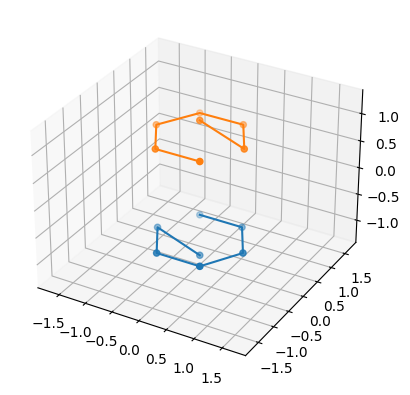

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(capas[:len(capas)//2,0], capas[:len(capas)//2,1], capas[:len(capas)//2,2])
ax.scatter(capas[len(capas)//2:,0], capas[len(capas)//2:,1], capas[len(capas)//2:,2])

ax.plot(capas[:len(capas)//2,0], capas[:len(capas)//2,1], capas[:len(capas)//2,2])
ax.plot(capas[len(capas)//2:,0], capas[len(capas)//2:,1], capas[len(capas)//2:,2])

plt.axis("equal"); plt.show()

## Solución de la ecuación de onda en 3 dimensiones.

$$ \phi_i(\vec{r}, t) = \phi(\vec{r} - \vec{r}_i, t) = A e^{i(\vec{k} \cdot (\vec{r} - \vec{r}_i)-\omega t)},\qquad  (\text{Para una sola fuente})$$

Finalmente

$$ \Phi(\vec{r}, t) = \sum_{i=1}^{N} \phi_i( \vec{r}, t), \qquad \text{(Aporte total)}$$

In [4]:
def onda_unit(r, pos, t, A=1, omega=20000):
    diff = r - pos; 
    k = 343 / omega
    k_ = diff/(np.linalg.norm(diff)) * k
    arg = 1j * (np.dot(k_, diff) - omega * t )
    s = A * np.exp(arg)
    return s.real

def onda_total(r, pos, t, A=1, omega=20000):
    s = 0
    for i in range(len(pos)):
        s += onda_unit(r, pos[i], t, A=A, omega=omega)
    return s 

In [5]:
r = np.array([0,1,0])
onda_total(r, capas, 0)

13.994724564852946

In [14]:
def graficar_onda(t, capas, x_lim=[-1,1], y_lim=[-1,1], z_lim=[-1,1], omega=1/20000):
    N = len(t)
    x_ = np.linspace(x_lim[0], x_lim[1], 10); 
    y_ = np.linspace(y_lim[0], y_lim[1], 10);
    z_ = np.linspace(z_lim[0], z_lim[1], 10);
    x, y, z = np.meshgrid(x_, y_, z_, sparse=False, indexing="xy")

    intensidad = np.zeros((len(t), len(x), len(y), len(z)))
    for tt in range(N):
        for i in range(len(x)):
            for j in range(len(y)):
                for k in range(len(z)):
                    intensidad[tt, i, j, k] = onda_total(np.array([x[i,j,k], y[i,j,k], z[i,j,k]]), capas, t[tt], omega=omega)
    intensidad /= np.max(abs(intensidad))
    # intensidad = np.array([onda_total(np.array([x[i,j,k], y[i,j,k], z[i,j,k]]), capas, t) for i in range(len(x)) for j in range(len(y)) for k in range(len(z))])
    
    fig = go.Figure(
        data = [
            go.Scatter3d(x=capas[:len(capas)//2,0], y=capas[:len(capas)//2,1], z=capas[:len(capas)//2,2], mode="lines"),
            go.Scatter3d(x=capas[len(capas)//2:,0], y=capas[len(capas)//2:,1], z=capas[len(capas)//2:,2], mode="lines"),
            go.Scatter3d(x=capas[:,0], y=capas[:,1], z=capas[:,2], mode="markers"),],
        layout = go.Layout(width=700, height=500,
                           scene = dict(
                               xaxis = dict(nticks=4, range=x_lim),
                               yaxis = dict(nticks=4, range=y_lim),
                               zaxis = dict(nticks=4, range=z_lim),),
                           title=f"Trampa acústica y evolución temporal de la onda",
                           hovermode="closest",
                           updatemenus=[dict(type="buttons",
                           buttons=[dict(label="Play",
                           method="animate",
                           args=[None])])]),
        frames=[go.Frame(
            data=[
                go.Volume(
                    x=x.flatten(), y=y.flatten(), z=z.flatten(),
                    value=intensidad[k].flatten(),
                    isomin=-1, isomax=1,
                    opacity=0.08, # needs to be small to see through all surfaces
                    surface_count=1000), # needs to be a large number for good volume rendering
            ])
            for k in range(N)]
        )
    fig.show()

In [15]:
t = np.linspace(0, 0.0002, num=15)
graficar_onda(t, capas, x_lim=[-1.5, 1.5], y_lim=[-1.5, 1.5], z_lim=[-1.5, 1.5], omega=20000)

In [8]:
# 